In [2]:
# Data manipulation
import pandas as pd
import numpy as np

# Modeling
import lightgbm as lgb

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5

In [3]:
features = pd.read_csv('train_clean.csv')

# Sample 16000 rows (10000 for training, 6000 for testing)
features = features.sample(n = 16000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 242)
Test shape:  (6000, 242)


,Unnamed: 0,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
99825,99825,0,1,1,2,99000.0,562491.0,27189.0,454500.0,0.007330,...,0,0,0,0,0,0,0,0,0,0
208378,208378,0,0,0,0,157500.0,677664.0,34731.0,585000.0,0.024610,...,0,0,0,0,0,0,0,0,0,0
1309,1309,0,0,1,2,112500.0,864000.0,25393.5,864000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0
172223,172223,1,0,1,1,63000.0,180000.0,9000.0,180000.0,0.020246,...,0,0,0,0,0,0,0,0,0,0
258157,258157,0,1,1,0,202500.0,1193580.0,42417.0,855000.0,0.020713,...,0,0,0,0,0,0,1,0,1,0


In [4]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [5]:
# Default hyperparamters
hyperparameters = model.get_params()

# Using early stopping to determine number of estimators.
del hyperparameters['n_estimators']

# Perform cross validation with early stopping
cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)

# Highest score
best = cv_results['auc-mean'][-1]

# Standard deviation of best score
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium ROC AUC in cross validation was 0.70872 with std of 0.02046.
The ideal number of iterations was 30.


In [7]:
# Optimal number of esimators found in cv
model.n_estimators = len(cv_results['auc-mean'])

# Train and make predicions with model
model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71736 ROC AUC on the test set.


In [9]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [10]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [11]:
# Create the learning rate
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

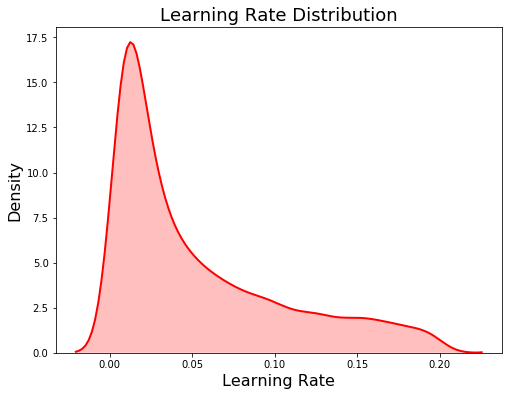

In [12]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

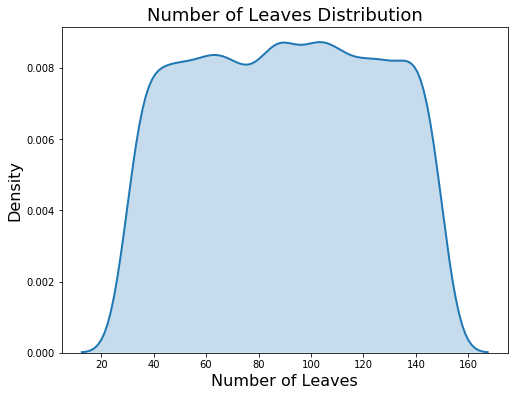

In [13]:
# Discrete uniform distribution
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [14]:
# boosting type domain 
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.5221297214457368}}

In [15]:
# Retrieve the subsample if present otherwise set to 1.0
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

# Extract the boosting type
hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'dart', 'subsample': 0.5221297214457368}

In [16]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [17]:
# Sample from the full space
x = sample(space)

# Conditional logic to assign top-level keys
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample

x

{'boosting_type': 'dart',
 'colsample_bytree': 0.6810829373241117,
 'is_unbalance': True,
 'learning_rate': 0.12999812813768608,
 'min_child_samples': 155.0,
 'num_leaves': 52.0,
 'reg_alpha': 0.48403229017648175,
 'reg_lambda': 0.17697521018144569,
 'subsample_for_bin': 200000.0,
 'subsample': 0.5721965614203572}

In [18]:
x = sample(space)
subsample = x['boosting_type'].get('subsample', 1.0)
x['boosting_type'] = x['boosting_type']['boosting_type']
x['subsample'] = subsample
x

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9834081010284755,
 'is_unbalance': True,
 'learning_rate': 0.03413723664520738,
 'min_child_samples': 185.0,
 'num_leaves': 22.0,
 'reg_alpha': 0.6352871671253901,
 'reg_lambda': 0.46166256760442126,
 'subsample_for_bin': 220000.0,
 'subsample': 0.5476379345925231}

In [19]:
# Create a new file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# Test the objective function
results = objective(sample(space))
print('The cross validation loss = {:.5f}.'.format(results['loss']))
print('The optimal number of estimators was {}.'.format(results['hyperparameters']['n_estimators']))

The cross validation loss = 0.27043.
The optimal number of estimators was 27.


In [20]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest

In [21]:
from hyperopt import Trials

# Record results
trials = Trials()

In [22]:
# Create a file and open a connection
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [24]:
from hyperopt import fmin

In [ ]:
# Global variable
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

 20%|██        | 1/5 [00:01<00:05,  1.43s/it, best loss: 0.28210190152236936]

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\callback.py:192: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



In [ ]:
# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

In [ ]:
results = pd.read_csv(OUT_FILE)

In [ ]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [ ]:
bayes_results = evaluate(results, name = 'Bayesian')
bayes_results

In [ ]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

To save the `Trials` object so it can be read in later for more training, we can use the `json` format. 

In [ ]:
import json

# Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
# MAX_EVALS = 1000

# # Create a new file and open a connection
# OUT_FILE = 'bayesian_trials_1000.csv'
# of_connection = open(OUT_FILE, 'w')
# writer = csv.writer(of_connection)

# # Write column names
# headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
# writer.writerow(headers)
# of_connection.close()

# # Record results
# trials = Trials()

# global ITERATION

# ITERATION = 0 

# best = fmin(fn = objective, space = space, algo = tpe.suggest,
#             trials = trials, max_evals = MAX_EVALS)

# # Sort the trials with lowest loss (highest AUC) first
# trials_dict = sorted(trials.results, key = lambda x: x['loss'])

# print('Finished, best results')
# print(trials_dict[:1])

# # Save the trial results
# with open('trials.json', 'w') as f:
#     f.write(json.dumps(trials_dict))

## Learning Rate Distribution 

In [ ]:
bayes_results = pd.read_csv('../input/home-credit-model-tuning/bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results = pd.read_csv('../input/home-credit-model-tuning/random_search_trials_1000.csv').sort_values('score', ascending = False).reset_index()
random_results['loss'] = 1 - random_results['score']

bayes_params = evaluate(bayes_results, name = 'Bayesian')
random_params = evaluate(random_results, name = 'random')

In [ ]:
# Dataframe of just scores
scores = pd.DataFrame({'ROC AUC': random_params['score'], 'iteration': random_params['iteration'], 'search': 'Random'})
scores = scores.append(pd.DataFrame({'ROC AUC': bayes_params['score'], 'iteration': bayes_params['iteration'], 'search': 'Bayesian'}))

scores['ROC AUC'] = scores['ROC AUC'].astype(np.float32)
scores['iteration'] = scores['iteration'].astype(np.int32)

scores.head()

In [ ]:
best_random_params = random_params.iloc[random_params['score'].idxmax(), :].copy()
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

In [ ]:
# Plot of scores over the course of searching
sns.lmplot('iteration', 'ROC AUC', hue = 'search', data = scores, size = 8);
plt.scatter(best_bayes_params['iteration'], best_bayes_params['score'], marker = '*', s = 400, c = 'orange', edgecolor = 'k')
plt.scatter(best_random_params['iteration'], best_random_params['score'], marker = '*', s = 400, c = 'blue', edgecolor = 'k')
plt.xlabel('Iteration'); plt.ylabel('ROC AUC'); plt.title("Validation ROC AUC versus Iteration");

In [ ]:
import altair as alt

alt.renderers.enable('notebook')

c = alt.Chart(scores).mark_circle().encode(x = 'iteration', y = alt.Y('ROC AUC', 
                                                                  scale = alt.Scale(domain = [0.64, 0.74])),
                                       color = 'search')
c.title = 'Validation ROC AUC vs Iteration'
c

In [ ]:
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18

# Density plots of the learning rate distributions 
sns.kdeplot(learning_rate_dist, label = 'Sampling Distribution', linewidth = 4)
sns.kdeplot(random_params['learning_rate'], label = 'Random Search', linewidth = 4)
sns.kdeplot(bayes_params['learning_rate'], label = 'Bayes Optimization', linewidth = 4)
plt.vlines([best_random_params['learning_rate'], best_bayes_params['learning_rate']],
           ymin = 0.0, ymax = 50.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.legend()
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');

In [ ]:
# Iterate through each hyperparameter
for i, hyper in enumerate(random_params.columns):
    if hyper not in ['class_weight', 'n_estimators', 'score', 'is_unbalance',
                    'boosting_type', 'iteration', 'subsample', 'metric', 'verbose', 'loss', 'learning_rate']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hyper != 'loss':
            sns.kdeplot([sample(space[hyper]) for _ in range(1000)], label = 'Sampling Distribution', linewidth = 4)
        sns.kdeplot(random_params[hyper], label = 'Random Search', linewidth = 4)
        sns.kdeplot(bayes_params[hyper], label = 'Bayes Optimization', linewidth = 4)
        plt.vlines([best_random_params[hyper], best_bayes_params[hyper]],
                     ymin = 0.0, ymax = 10.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
        plt.legend(loc = 1)
        plt.title('{} Distribution'.format(hyper))
        plt.xlabel('{}'.format(hyper)); plt.ylabel('Density');
        plt.show();

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Plot of four hyperparameters
for i, hyper in enumerate(['colsample_bytree', 'learning_rate', 'min_child_samples', 'num_leaves']):
    
        # Scatterplot
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize = (24, 6))
i = 0

# Scatterplot of next three hyperparameters
for i, hyper in enumerate(['reg_alpha', 'reg_lambda', 'subsample_for_bin', 'subsample']):
        sns.regplot('iteration', hyper, data = bayes_params, ax = axs[i])
        axs[i].scatter(best_bayes_params['iteration'], best_bayes_params[hyper], marker = '*', s = 200, c = 'k')
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hyper), title = '{} over Search'.format(hyper));

plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(1, 2, sharey = True, sharex = True)

# Bar plots of boosting type
random_params['boosting_type'].value_counts().plot.bar(ax = axs[0], figsize = (14, 6), color = 'orange', title = 'Random Search Boosting Type')
bayes_params['boosting_type'].value_counts().plot.bar(ax = axs[1], figsize = (14, 6), color = 'green', title = 'Bayes Optimization Boosting Type');

In [ ]:
bars = alt.Chart(random_params, width = 500).mark_bar(color = 'orange').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 400])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

In [ ]:
bars = alt.Chart(bayes_params, width = 500).mark_bar(color = 'green').encode(x = 'boosting_type', y = alt.Y('count()', scale = alt.Scale(domain = [0, 800])))
text = bars.mark_text(size = 20, align = 'center', baseline = 'bottom').encode(text = 'count()')

bars + text

In [ ]:
# Read in full dataset
train = pd.read_csv('../input/home-credit-simple-featuers/simple_features_train.csv')
test = pd.read_csv('../input/home-credit-simple-featuers/simple_features_test.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
random_results['hyperparameters'] = random_results['hyperparameters'].map(ast.literal_eval)
bayes_results['hyperparameters'] = bayes_results['hyperparameters'].map(ast.literal_eval)

### Random Search on the Full Dataset

In [ ]:
train_set = lgb.Dataset(train, label = train_labels)

hyperparameters = dict(**random_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset  for Random Search= {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

Then we can make predictions on the test data. The predictions are saved to a csv file that can be submitted to the competition.

In [ ]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_random_search.csv', index = False)

Submitting these to the competition results in a score of __0.787__ which compares to the original score from the kernel of __0.792__

### Bayesian Optimization on the Full Dataset

In [ ]:
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))